In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
from eofs.xarray import Eof
import cartopy.crs as ccrs

ERA5 November SST anomalies

In [5]:
# November average sea surface temperature anomalies in the North Atlantic region (1940-2014)
era_nov_sst_anoms = xr.open_dataset("/../../gws/nopw/j04/extant/users/slbennie/CVDP_outputs/ens_mean_spat/psl/epoch_analysis_psl_mon_historical_HadGEM3-GC31-LL_1850_1995_19.nc")

November SST anomaly EOFs

In [8]:
# Create an EOF solver to do the EOF analysis
# Square-root of cosine of latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(era_nov_sst_anoms["lat"].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

solver = Eof(era_nov_sst_anoms["psl"], weights=wgts)

# calculate the first 3 eofs of november sst anomalies
# expressed as the correlation between the PC time series and the input SST anomalies at each grid point
eofs = solver.eofsAsCorrelation(neofs=3)

# calculate the first 3 principle components (how EOFs vary over time)
pcs = solver.pcs(npcs=3, pcscaling=1)

# fraction of the total variance explained by each eof
variance_fractions = solver.varianceFraction(neigs=3)

ValueError: cannot find a time coordinate (must be called "time", have a numpy.datetime64 dtype, or have an attribute named "axis" with value "T")

NameError: name 'eofs' is not defined

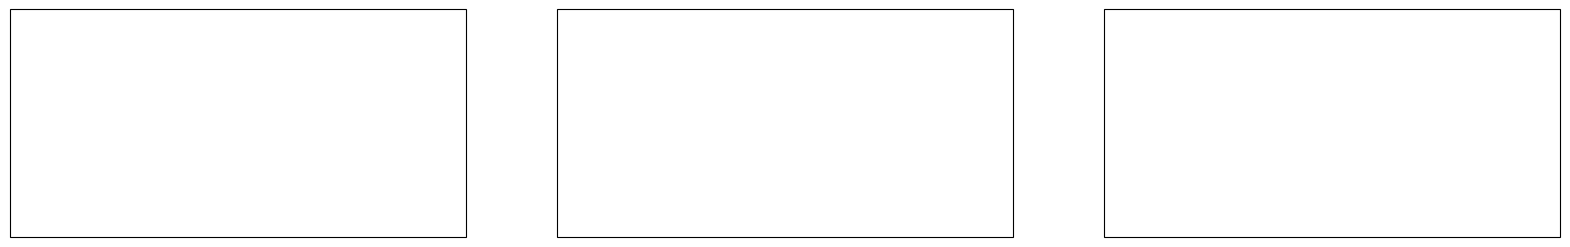

In [7]:
#plot the first three eofs

fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(20, 15), subplot_kw={"projection": ccrs.PlateCarree()}
)

for i, ax in enumerate(axes.flat[:3]):
    c = ax.contourf(
        eofs[0].lon,
        eofs[0].lat,
        eofs[i],
        levels=20,
        cmap="coolwarm",
        transform=ccrs.PlateCarree(),
    )
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor="white", edgecolor="black")
    ax.set_title(
        f"EOF{i+1} ({variance_fractions.values[i]*100:.2f}% variance)", fontsize=14
    )

plt.show()

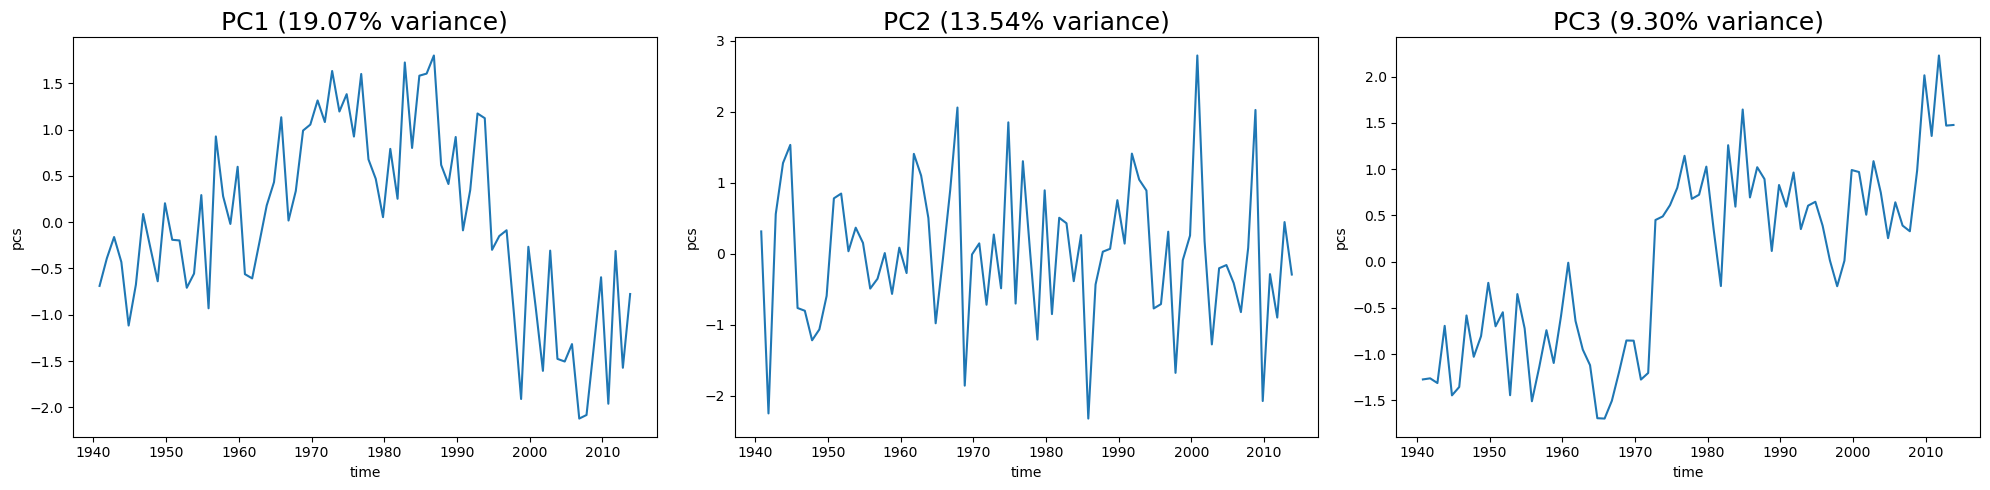

In [5]:
# Plot the first three principal components as time series

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

for i, ax in enumerate(axes.flat[:3]):
    pcs.isel(mode=i).plot(ax=ax)
    ax.set_title(
        f"PC{i+1} ({variance_fractions.values[i]*100:.2f}% variance)", fontsize=18
    )

plt.tight_layout()
plt.show()

Pseudo-PC

In [11]:
# SST anomaly pattern to project November SST anomalies onto
era5_sst_nov_regression_pattern = xr.open_dataset("/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/historical/historical_NAO/HadGEM3-GC31-LL_EM.cvdp_data.nao.1850-2014.nc")

ERA5 november sst anomalies projected onto era5 regression pattern

In [13]:
# Weight SST data by coslat to account for grid cell area decreasing with latitude
#weights = np.cos(np.radians(era_nov_sst_anoms["lat"].values))
#weights_2d_era = weights[:, np.newaxis]

# weight sst anomalies by area of each gridcell
#weighted_sst = era_nov_sst_anoms["psl"] * weights_2d_era
#weighted_regression = np.nan_to_num(era5_sst_nov_regression_pattern * weights_2d_era)

# Combine lat and lon dimensions
#weighted_sst_flat = weighted_sst.stack(spatial=["lat", "lon"])
weighted_psl_flat = 

# flatten weighted regression pattern
regression_flat = weighted_regression.flatten()

# dot product (weighted projection) between 
# the weighted SST anomalies and regression pattern
weighted_projection = (weighted_sst_flat * regression_flat).sum(dim="spatial")

# normalise for unit variance
total_variance = np.sum(regression_flat**2)

era_nov_sst_index = weighted_projection / total_variance

ValueError: dimensions ('TIME',) must have the same length as the number of data dimensions, ndim=2

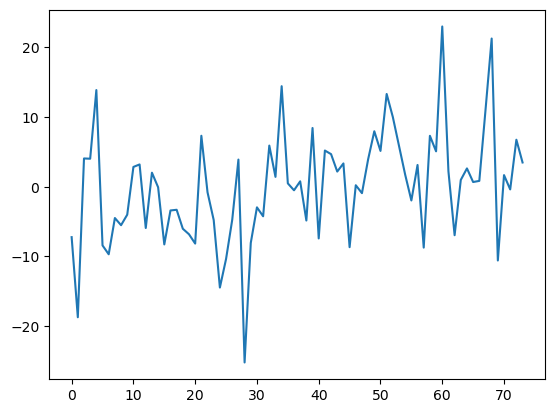

In [8]:
plt.plot(era_nov_sst_index)

Model november sst anomalies projected onto era5 regression pattern

In [9]:
# Ensembles of November SST indices, where each member has 74 Novembers
canesm5_nov_sst_indices = xr.load_dataarray(
    "/nfs/annie/ee22ya/dev/air_sea/air_sea_data/cmip_nao_sst/CanESM5/SST_NAOI_regression/CanESM5_nov_sst_indices.nc"
)
IPSL_nov_sst_indices = xr.load_dataarray(
    "/nfs/annie/ee22ya/dev/air_sea/air_sea_data/cmip_nao_sst/IPSL-CM6A-LR/SST_NAOI_regression/IPSL_nov_sst_indices.nc"
)
ACCESS_nov_sst_indices = xr.load_dataarray(
    "/nfs/annie/ee22ya/dev/air_sea/air_sea_data/cmip_nao_sst/ACCESS-ESM1-5/SST_NAOI_regression/ACCESS_nov_sst_indices.nc"
)
MIROC6_nov_sst_indices = xr.load_dataarray(
    "/nfs/annie/ee22ya/dev/air_sea/air_sea_data/cmip_nao_sst/MIROC6/SST_NAOI_regression/MIROC6_nov_sst_indices.nc"
)

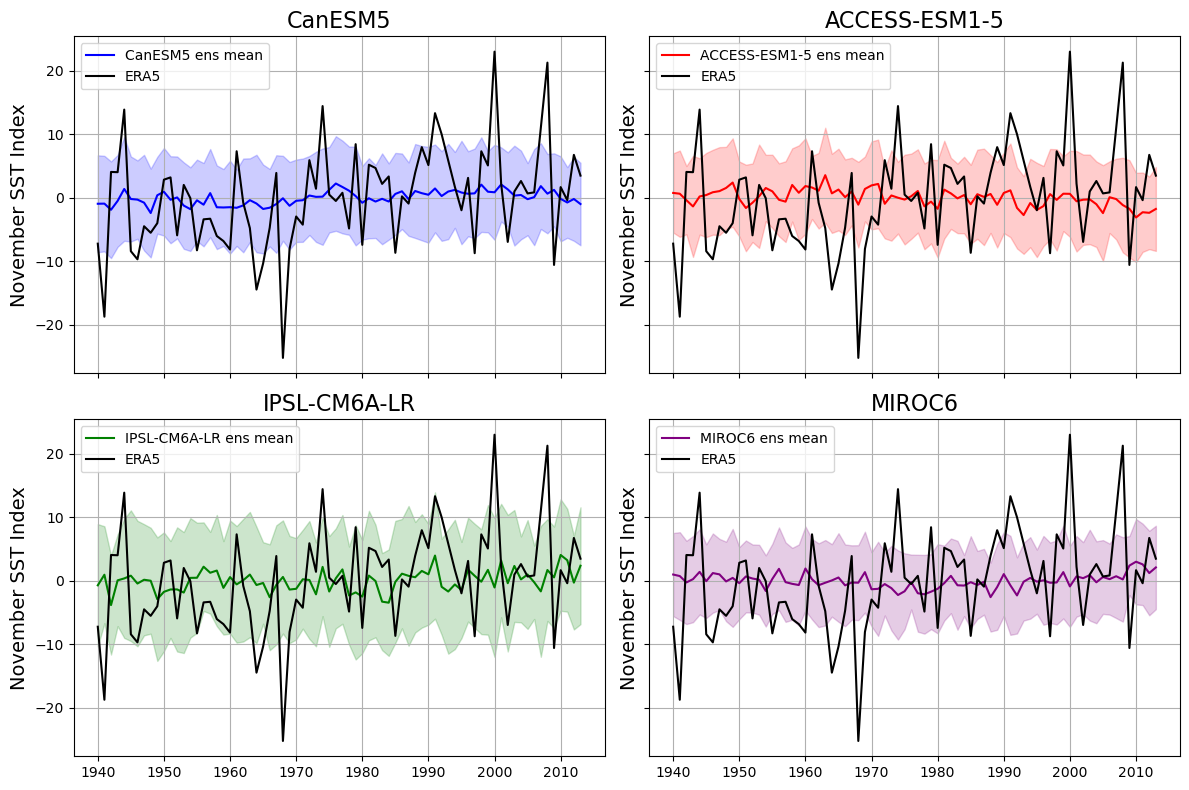

In [10]:
models = {
    "CanESM5": canesm5_nov_sst_indices,
    "ACCESS-ESM1-5": ACCESS_nov_sst_indices,
    "IPSL-CM6A-LR": IPSL_nov_sst_indices,
    "MIROC6": MIROC6_nov_sst_indices,
}

colors = {
    "CanESM5": "blue",
    "ACCESS-ESM1-5": "red",
    "IPSL-CM6A-LR": "green",
    "MIROC6": "purple",
}

years_unique = np.unique(canesm5_nov_sst_indices.time.dt.year)
era_data = era_nov_sst_index


fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, (model_name, model_data) in enumerate(models.items()):
    ax = axes[i]

    # Calculate ensemble mean and std deviation for the model
    ens_mean = model_data.mean(dim="member")
    std_devs = [
        model_data.sel(time=model_data.time.dt.year == year).std()
        for year in years_unique
    ]
    ax.plot(
        years_unique,
        ens_mean.sel(time=ens_mean.time.dt.year.isin(years_unique)),
        label=f"{model_name} ens mean",
        color=colors[model_name],
    )
    ax.fill_between(
        years_unique,
        ens_mean.sel(time=ens_mean.time.dt.year.isin(years_unique)) - std_devs,
        ens_mean.sel(time=ens_mean.time.dt.year.isin(years_unique)) + std_devs,
        color=colors[model_name],
        alpha=0.2,
    )

    ax.plot(
        years_unique,
        era_data,
        label="ERA5",
        color="black",
    )
    ax.set_title(f"{model_name}", fontsize=16)
    ax.set_ylabel("November SST Index", fontsize=14)
    ax.grid(True)
    ax.legend()


plt.tight_layout()
# plt.savefig(
#     "/nfs/annie/ee22ya/dev/air_sea/Figures/nov_sst_onto_era5.png", bbox_inches="tight"
# )
plt.show()